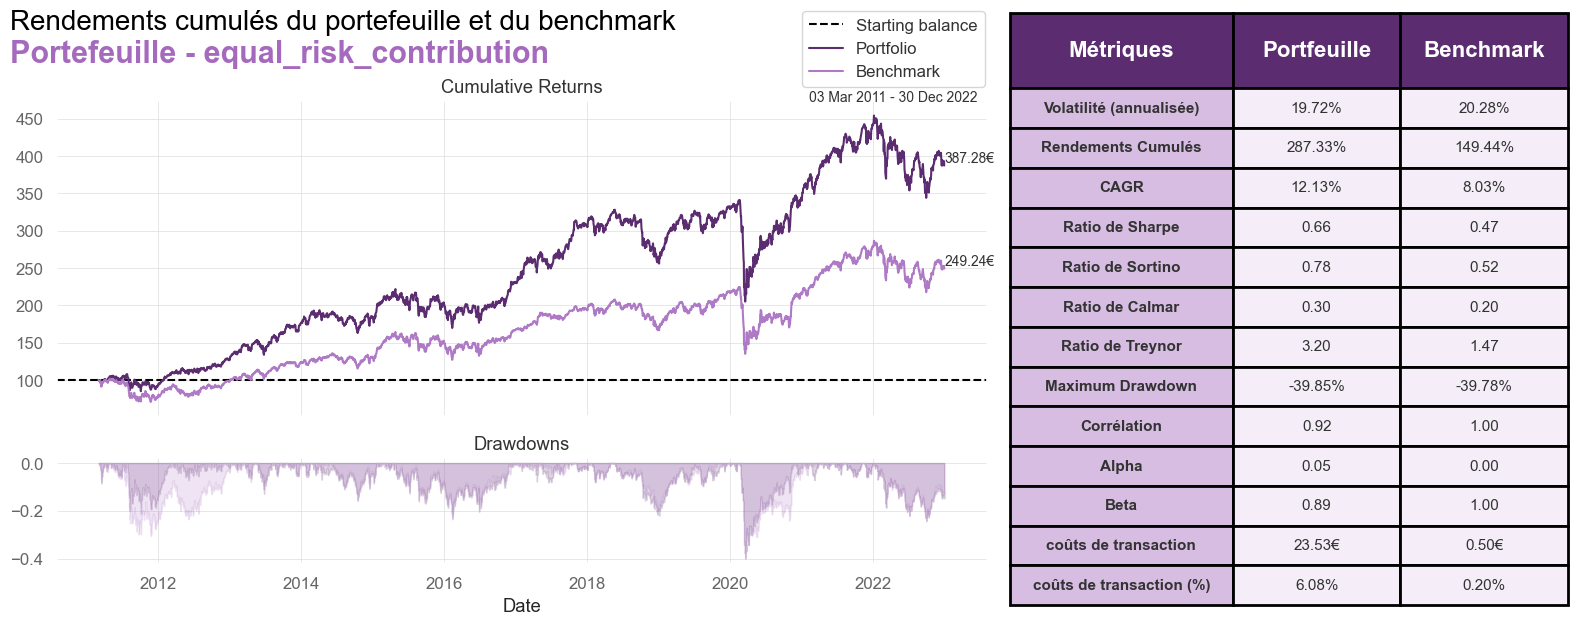

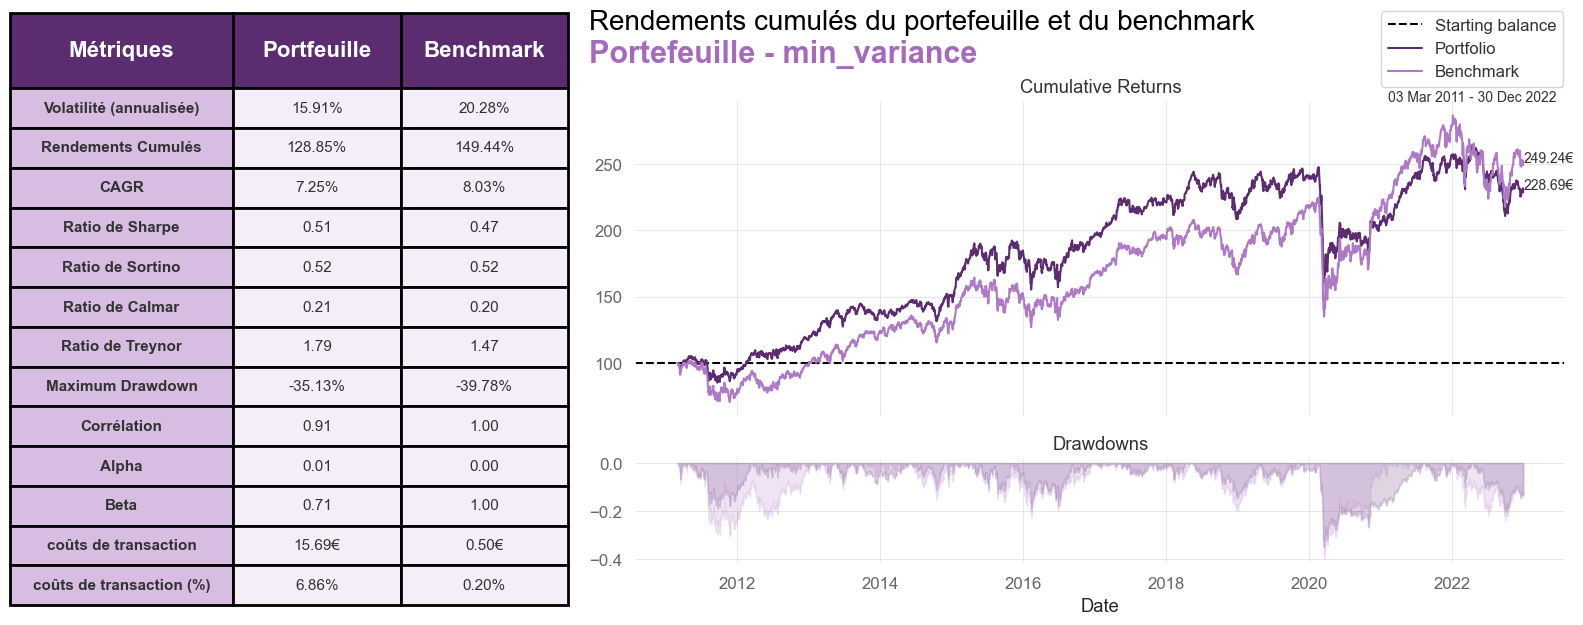

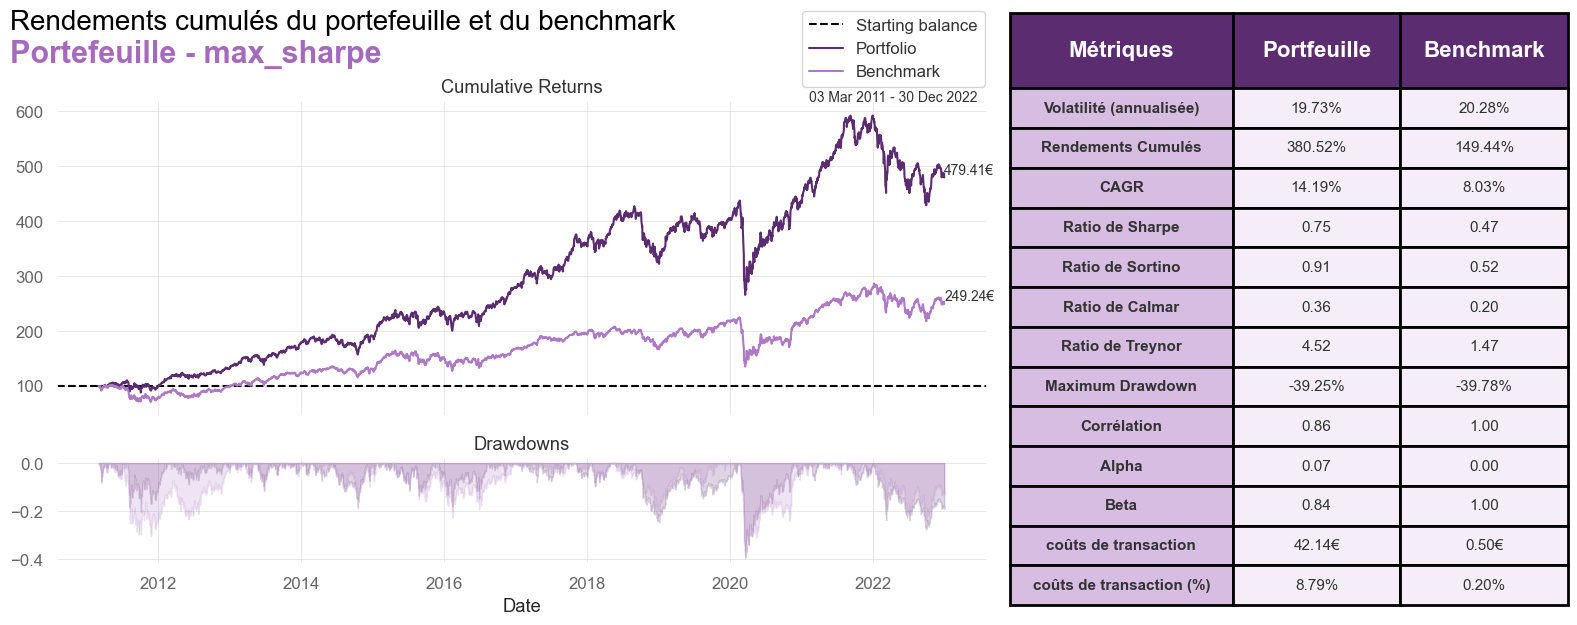

'\nbacktest("equal_risk_contribution",\n\n        benchmark = "equal_weight", # Benchmark à utiliser pour le backtest\n        returns = returns, # DataFrame contenant les rendements des actions\n        num_clusters = 10,  # Nombre de clusters désiré, semblable au nombre de secteurs\n        risk_free_rate = 0.02,  # Taux sans risque (10 ans)\n        min_weight = 0.00,  # Poids minimum par action\n        max_weight = 0.25,  # Poids maximum par action\n        min_weight_sector = 0.01,  # Poids minimum par secteur\n        max_weight_sector = 0.3,  # Poids maximum par secteur\n        total_exposure = 1, # Exposition totale du portefeuille\n        target_variance = 0.20, # Variance cible du portefeuille\n        balance = 100, # Balance initiale du portefeuille\n\n        start_date = \'2020-01-01\', # Date de début du backtest (Attention, la période d\'entrainement doit être incluse dans cette période)\n        end_date = \'2022-12-30\', # Date de fin du backtest\n\n        freq_re

In [71]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

'''
Le code à la structure suivante :
- Fonctions de clustering
- Fonctions de création de contraintes
- Fonctions d'optimisation
- Fonctions de backtesting
- Fonctions de calcul de ratios
- Fonctions de visualisation

Les fonctions de clustering et de création de contraintes sont utilisées dans les fonctions d'optimisation.
Les fonctions d'optimisation sont utilisées dans les fonctions de backtesting.
Les les résultats du backtesting sont utilisées dans les fonctions de calcul de ratios et visualisation.

J'ai conscience que le code est un peu conséquent. J'ai pour projet de le passer en objet pour le rendre plus lisible et plus facilement utilisable.
'''


def create_clusters(returns, num_clusters):
    """
    Créer des clusters à partir des rendements des actions. L'objectif est de regrouper les actions
    qui sont similaires pour simuler des secteurs d'activitées.
    Le but d'ajouter des secteurs est de contraindre le portefeuille à avoir des poids 
    minimum et maximum par secteur, pour maximiser la diversification.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à créer.

    Returns:
    DataFrame: DataFrame contenant les tickers des actions et leurs labels de cluster.
    """
    # Calculer la matrice de corrélation de Pearson
    correlation_matrix = returns.corr(method='pearson')

    # Convertir les coefficients de corrélation en distances
    distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))

    # Convertir la matrice de distances en format "condensed"
    condensed_distance_matrix = squareform(distance_matrix, checks=False)

    # Effectuer un clustering hiérarchique en utilisant la méthode d'agglomération de Ward
    linked = linkage(condensed_distance_matrix, method='ward')

    # Générer les labels de cluster
    cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

    # Créer un DataFrame avec les labels de cluster et les tickers correspondants
    clustered_data = pd.DataFrame({'Ticker': returns.columns, 'Cluster': cluster_labels})

    return clustered_data

def create_sector_constraints(clustered_data, min_weight_sector, max_weight_sector):
    """
    Crée des contraintes sectorielles pour l'optimisation du portefeuille.

    Parameters:
    clustered_data (DataFrame): DataFrame contenant les tickers des actions et leurs labels de cluster.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.

    Returns:
    list: Liste des contraintes sectorielles pour l'optimisation du portefeuille.
    """
    constraints = []

    # Parcourir chaque secteur unique dans les données clusterisées
    for sector in clustered_data['Cluster'].unique():
        # Trouver les indices des actions appartenant à ce secteur
        sector_indices = clustered_data[clustered_data['Cluster'] == sector].index

        # Définir une contrainte de poids minimum pour le secteur
        # Cette fonction s'assure que la somme des poids des actions dans le secteur est au moins égale à min_weight_sector
        def sector_min_constraint(weights, sector_indices=sector_indices, min_weight=min_weight_sector):
            return np.sum(weights[sector_indices]) - min_weight

        # Définir une contrainte de poids maximum pour le secteur
        # Cette fonction s'assure que la somme des poids des actions dans le secteur n'excède pas max_weight_sector
        def sector_max_constraint(weights, sector_indices=sector_indices, max_weight=max_weight_sector):
            return max_weight - np.sum(weights[sector_indices])

        # Ajouter les contraintes de poids minimum et maximum à la liste des contraintes
        constraints.append({'type': 'ineq', 'fun': sector_min_constraint})
        constraints.append({'type': 'ineq', 'fun': sector_max_constraint})

    # Retourner la liste complète des contraintes
    return constraints

def create_portfolio_constraints(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, total_exposure, previous_weights, max_weight_change):
    """
    Crée l'ensemble des contraintes pour l'optimisation du portefeuille, incluant les contraintes générales, sectorielles, et la contrainte de changement maximal des poids.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.
    total_exposure (float): Exposition totale du portefeuille (généralement 1 pour 100%).
    previous_weights (array): Les poids précédents du portefeuille.
    max_weight_change (float): Pourcentage maximum de changement autorisé pour les poids des actifs.

    Returns:
    list: Liste complète des contraintes pour l'optimisation du portefeuille.
    """
    # Contraintes de base pour le portefeuille
    portfolio_constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - total_exposure},
        {'type': 'ineq', 'fun': lambda x: max_weight - x},
        {'type': 'ineq', 'fun': lambda x: x - min_weight}
    ]

    # Créer les clusters à partir des rendements
    clustered_data = create_clusters(returns, num_clusters)

    # Ajouter les contraintes sectorielles
    sector_constraints = create_sector_constraints(clustered_data, min_weight_sector, max_weight_sector)
    portfolio_constraints.extend(sector_constraints)
    

    # Contrainte pour le changement maximal des poids
    def weight_change_constraint(weights, previous_weights=previous_weights, max_change=max_weight_change):
        # Calculer le changement total en poids en termes de pourcentage
        total_change = np.sum(np.abs(weights - previous_weights))
        return max_change - total_change

    portfolio_constraints.append({'type': 'ineq', 'fun': weight_change_constraint})

    return portfolio_constraints


def equal_risk_contribution(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change):
    """
    Optimise les poids des actifs pour atteindre une contribution égale au risque.
    Basé les travaux de Ze Vinicius et Daniel P. Palomar.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.

    Returns:
    numpy.array: Poids optimaux des actifs pour une contribution égale au risque.
    """

    # Créer les contraintes du portefeuille
    portfolio_constraints = create_portfolio_constraints(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, total_exposure, previous_weights, max_weight_change)

    # Calculer la matrice de covariance
    cov_matrix = returns.cov()

    # Calculer les rendements attendus
    mu = returns.mean()

    # Définir le paramètre lambda mu, une valeur 1 est considéré comme une maximisation du rendement estimé (donc similaire à la maximisation du sharpe ratio)
    lmd_mu = 0.25

    # Définir le paramètre lambda var, une valeur 1 est considéré comme une minimisation de la variance
    lmd_var = 0.1

    def minimize_risk_concentration(weights, covariance_matrix):
        """
        Fonction objectif pour minimiser la concentration de risque dans un portefeuille.

        Parameters:
        weights (numpy.array): Vecteur des poids des actifs dans le portefeuille.
        covariance_matrix (numpy.array): Matrice de covariance des rendements des actifs.

        Returns:
        float: Valeur de la fonction objectif.
        """
        N = len(weights)
        risk_contributions = np.dot(covariance_matrix, weights)
        objective_value = 0
        for i in range(N):
            for j in range(N):
                objective_value += (weights[i] * risk_contributions[i] - weights[j] * risk_contributions[j])
        return objective_value ** 2

    def objective(weights, cov_matrix, mu, lmd_mu, num_assets):
        #risk_contributions = ((cov_matrix @ weights) * weights) / np.sqrt((weights.T @ cov_matrix @ weights))
        risk_objective = minimize_risk_concentration(weights, cov_matrix) # ou "np.sum((risk_contributions - 1 / num_assets)**2)" Les deux fonctionnent, mais différement, j'ai du mal à cerner si l'une est meilleure que l'autre.
        return_value_objective = -lmd_mu * weights.T @ mu
        variance_objective = lmd_var * weights.T @ cov_matrix @ weights
        return risk_objective + return_value_objective + variance_objective
  

    # Définir les poids minimum et maximum pour chaque action
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Initialiser les poids de manière égale
    initial_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    # Nombre d'actifs
    num_assets = len(returns.columns)

    # Objectif de la fonction à optimiser
    def new_objective(weights):
        return objective(weights, cov_matrix, mu, lmd_mu, num_assets)

    # Optimisation
    result = minimize(new_objective, 
                      initial_weights, 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=portfolio_constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("L'optimisation n'a pas réussi: " + result.message)

def optimize_min_variance(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change):
    """
    Effectue l'optimisation pour minimiser la variance du portefeuille.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.

    Returns:
    numpy.array: Les poids optimaux pour chaque action dans le portefeuille.
    """
    # Créer les contraintes du portefeuille
    portfolio_constraints = create_portfolio_constraints(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, total_exposure, previous_weights, max_weight_change)

    # Calculer la matrice de covariance
    cov_matrix = returns.cov()

    # Définir les poids minimum et maximum pour chaque action
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Initialiser les poids de manière égale
    initial_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    # Fonction pour calculer la variance du portefeuille
    def portfolio_variance(weights, covariance_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)) * 250)

    # Effectuer l'optimisation
    result = minimize(portfolio_variance, 
                      previous_weights, 
                      args=(cov_matrix,), 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=portfolio_constraints)

    if result.success:
        return result.x  # Les poids optimaux
    else:
        raise ValueError("L'optimisation n'a pas réussi: " + result.message)

def optimize_max_sharpe(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change):
    """
    Effectue l'optimisation pour minimiser la variance du portefeuille.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.

    Returns:
    numpy.array: Les poids optimaux pour chaque action dans le portefeuille.
    """
    # Créer les contraintes du portefeuille
    portfolio_constraints = create_portfolio_constraints(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, total_exposure, previous_weights, max_weight_change)

    # Calculer la matrice de covariance
    cov_matrix = returns.cov()

    # Calculer les rendements attendus
    expected_returns = returns.mean()

    # Définir les poids minimum et maximum pour chaque action
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Initialiser les poids de manière égale
    initial_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    # Fonction pour calculer la variance du portefeuille
    def negative_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate):
        portfolio_return = np.sum(expected_returns * weights) * 250
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)) * 250)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # Négatif car nous voulons maximiser

    # Effectuer l'optimisation
    result = minimize(negative_sharpe_ratio, 
                      previous_weights, 
                      args=(expected_returns, cov_matrix, risk_free_rate), 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=portfolio_constraints)

    if result.success:
        return result.x  # Les poids optimaux
    else:
        raise ValueError("L'optimisation n'a pas réussi: " + result.message)

def optimize_target_variance(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change, target_variance):
    """
    Effectue l'optimisation pour atteindre une variance cible du portefeuille.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.
    target_variance (float): La variance cible pour le portefeuille.

    Returns:
    numpy.array: Les poids optimaux pour chaque action dans le portefeuille.
    """
    # Créer les contraintes du portefeuille
    portfolio_constraints = create_portfolio_constraints(returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, total_exposure, previous_weights, max_weight_change)

    # Calculer la matrice de covariance
    cov_matrix = returns.cov()

    # Définir les poids minimum et maximum pour chaque action
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Initialiser les poids de manière égale
    initial_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    # Fonction pour calculer la différence entre la variance du portefeuille et la variance cible
    def portfolio_variance_difference(weights, covariance_matrix):
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights)) * 250
        return np.abs(portfolio_variance - target_variance)

    # Effectuer l'optimisation
    result = minimize(portfolio_variance_difference, 
                      initial_weights, 
                      args=(cov_matrix,), 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=portfolio_constraints)

    if result.success:
        return result.x  # Les poids optimaux
    else:
        raise ValueError("L'optimisation n'a pas réussi: " + result.message)

def benchmark_equal_weight(returns):
    # Initialiser les poids de manière égale
    initial_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    return initial_weights



def get_optimal_weights(portefeuille, benchmark, full_returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, start_date, end_date, freq_rebalancing, train_window, max_weight_change, starting):
    """
    Effectue un backtest sur les données historiques pour tester la performance de la stratégie d'optimisation.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.
    risk_free_rate (float): Taux sans risque.
    total_exposure (float): Exposition totale du portefeuille.
    freq_rebalancing (int): Fréquence de rebalancement en jours.
    train_window (int): Période d'entraînement en jours.
    start_date (str): Date de début du backtest.
    end_date (str): Date de fin du backtest.


    Returns:
    DataFrame: DataFrame contenant les poids optimaux pour chaque action à chaque date de rebalancement.
    """

    # Initialiser les DataFrames pour les poids optimaux et les poids du benchmark
    optimal_weights_df = pd.DataFrame()
    benchmark_weights_df = pd.DataFrame()

    # Définir les paramètres de rééquilibrage
    freq_rebalancing_dt = pd.DateOffset(days=freq_rebalancing)  # Fréquence de rééquilibrage en jours
    train_window_dt = pd.DateOffset(days=train_window)  # Période d'entraînement en jours

    start_date_with_window = (pd.to_datetime(start_date) - train_window_dt).strftime('%Y-%m-%d')
    
    returns = full_returns["2010":end_date]
    # Définir la date de début pour la boucle
    current_date = returns.index[-1]

    previous_weights = np.array([1/returns.shape[1]] * returns.shape[1])

    first_iteration = True

    while current_date > returns.index[0] + train_window_dt:

        # Définir la période d'entraînement ((Ici je soustrais 1 jour pour éviter de prendre en compte les données de la journée courante, que potentiellement on ne connait pas encore)
        train_start = current_date - train_window_dt
        train_end = current_date - pd.DateOffset(days=1)
        
        # Sélectionner les données de la période d'entraînement
        ret_inter = returns[train_start:train_end]

        if first_iteration == True and starting == "strategy":
            if portefeuille == "min_variance":
                optimal_weights = optimize_min_variance(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, 1)

            elif portefeuille == "max_sharpe":
                optimal_weights = optimize_max_sharpe(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, 1)

            elif portefeuille == "target_variance":
                optimal_weights = optimize_target_variance(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, 1, target_variance)

            elif portefeuille == "equal_weight":
                optimal_weights = benchmark_equal_weight(ret_inter)

            elif portefeuille == "equal_risk_contribution":
                optimal_weights = equal_risk_contribution(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, 1)


            else:
                raise ValueError("Le portefeuille n'existe pas")

        else:

            if portefeuille == "min_variance":
                optimal_weights = optimize_min_variance(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change)

            elif portefeuille == "max_sharpe":
                optimal_weights = optimize_max_sharpe(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change)

            elif portefeuille == "target_variance":
                optimal_weights = optimize_target_variance(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change, target_variance)

            elif portefeuille == "equal_weight":
                optimal_weights = benchmark_equal_weight(ret_inter)
            
            elif portefeuille == "equal_risk_contribution":
                optimal_weights = equal_risk_contribution(ret_inter, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, previous_weights, max_weight_change)

            else:
                raise ValueError("Le portefeuille n'existe pas")


        if benchmark == "equal_weight":
            benchmark_weights = benchmark_equal_weight(ret_inter)
        else:
            raise ValueError("Le benchmark n'existe pas")

        # Concaténer les poids optimaux au DataFrame

        previous_weights = optimal_weights

        optimal_weights_df = pd.concat([optimal_weights_df, pd.DataFrame([optimal_weights], columns=ret_inter.columns, index=[current_date])])
        benchmark_weights_df = pd.concat([benchmark_weights_df, pd.DataFrame([benchmark_weights], columns=ret_inter.columns, index=[current_date])])

        # Mettre à jour la date courante
        current_date -= freq_rebalancing_dt

        first_iteration = False

    return optimal_weights_df, benchmark_weights_df

def calculate_portfolio_performance(full_df, weights_df, balance, start_date, end_date, transaction_cost):
    """
    Calcule la performance d'un portefeuille en utilisant un DataFrame de prix et un DataFrame de poids optimaux.

    Parameters:
    df (DataFrame): DataFrame contenant les prix des actifs.
    weights_df (DataFrame): DataFrame contenant les poids optimaux pour chaque actif à différentes dates.

    Returns:
    Series: Série représentant la performance cumulée du portefeuille.
    """
    # Trouver la première date où les poids optimaux sont disponibles
    first_valid_date = weights_df.last_valid_index()
    
    df = full_df[start_date:end_date]

    # Initialiser une série pour stocker la valeur du portefeuille
    portfolio_value = pd.Series(index=df.loc[first_valid_date:].index)

    #Ajouter une première valeur à la série pour la valeur du portefeuille au début du backtest
    portfolio_value.iloc[0] = balance

    # Variable pour stocker les poids actuels
    current_weights = weights_df.loc[first_valid_date]

    df = df.pct_change().dropna(axis=0)

    # Variable pour stocker la somme totale des coûts de transaction
    total_transaction_costs = 0

    # Initialiser la valeur précédente des poids à zéro
    previous_weights = pd.Series([0]*len(current_weights), index=current_weights.index)

    for date in df.loc[first_valid_date:].index:
        port_value = 0

        # Mettre à jour les poids si une nouvelle valeur est disponible
        if date in weights_df.index:
            new_weights = weights_df.loc[date]

            # Calculer les montants à acheter/vendre pour chaque actif
            changes = (new_weights - previous_weights) * balance

            # Calculer les coûts de transaction
            transaction_costs = changes.abs().sum() * (transaction_cost / 100)

            # Ajouter les coûts de transaction à la somme totale
            total_transaction_costs += transaction_costs

            # Soustraire les coûts de transaction de la balance
            balance -= transaction_costs

            current_weights = new_weights
            previous_weights = new_weights.copy()

        
        for i in range(len(current_weights)):
            port_value += current_weights.iloc[i] * (1 + df.iloc[df.index.get_loc(date), i]) * balance #La notation df.loc[date][i] est plus compréhensible, mais risque d'être dépricée dans le futur

        port_value += (1 - current_weights.sum()) * balance

        portfolio_value[date] = port_value
        balance = port_value

    return portfolio_value, total_transaction_costs



def ratios(prices, benchmark, total_transaction_costs, risk_free_rate=0.02, periods=252.0):
    """
    Calcule diverses métriques financières pour un portefeuille.

    Parameters:
    prices (DataFrame): DataFrame contenant les prix d'un portefeuille.
    benchmark (DataFrame): DataFrame contenant les prix d'un indice de référence.
    risk_free_rate (float): Le taux sans risque à utiliser dans les calculs (par défaut 0.02).
    periods (float): Le nombre de périodes par an (par défaut 252 pour des données quotidiennes).

    Returns:
    Series: Série contenant les métriques financières calculées du portefeuille.
    """

    # Nettoyage des données
    returns = prices.pct_change().dropna()  # Calculer les rendements du portefeuille
    benchmark = benchmark.pct_change().dropna()  # Calculer les rendements du benchmark
    
    # Covariance pour le calcul de bêta
    matrix = np.cov(returns, benchmark)  # Matrice de covariance
    beta = matrix[0, 1] / matrix[1, 1]  # Bêta du portefeuille par rapport au benchmark

    # Calcul d'alpha
    alpha = returns.mean() - beta * benchmark.mean()  # Alpha du portefeuille
    alpha = alpha * periods  # Annueliser alpha

    # Volatilité (écart-type)
    volatility = returns.std() * np.sqrt(periods)  # Calculer la volatilité annuelle du portefeuille

    # Retour cumulatif
    cumulative_return = (1 + returns).prod() - 1  # Calculer le rendement cumulatif

    # CAGR (Taux de croissance annuel composé)
    cagr = ((1 + cumulative_return) ** (1 / ((prices.index[-1] - prices.index[0]).days / 365.25))) - 1 #(prices.index[-1] - prices.index[0]).days) / 365.25

    # Ratio de Sharpe
    sharpe_ratio = (returns.mean() / returns.std(ddof=1)) * np.sqrt(periods)

    # Ratio de Sortino
    downside = np.sqrt((returns[returns < 0] ** 2).sum() / len(returns))  # Risque de baisse
    sortino_ratio = (returns - (np.power(1 + risk_free_rate, 1.0 / periods) - 1.0)).mean() / downside * np.sqrt(periods)

    # Drawdown maximal
    cum_returns = (1 + returns).cumprod()  # Retours cumulatifs
    peak = cum_returns.expanding(min_periods=1).max()  # Pics de performance
    drawdown = (cum_returns / peak) - 1  # Calculer le drawdown
    max_drawdown = drawdown.min()  # Drawdown maximal

    # Ratio de Calmar
    calmar_ratio = cagr / abs(max_drawdown)  # Calculer le ratio de Calmar

    # Corrélation
    correlation = returns.corr(benchmark)  # Corrélation entre le portefeuille et le benchmark

    # Ratio de Treynor
    treynor_ratio = (cumulative_return - risk_free_rate) / beta  # Calculer le ratio de Treynor

    # Total des coûts de transaction en pourcentage de la valeur du portefeuille à la fin de la période
    total_transaction_costs_pct = total_transaction_costs / prices.iloc[-1] * 100

    metrics = {
        "Volatilité (annualisée)": f"{volatility * 100:.2f}%",
        "Rendements Cumulés": f"{cumulative_return * 100:.2f}%",
        "CAGR": f"{cagr * 100:.2f}%",
        "Ratio de Sharpe": f"{sharpe_ratio:.2f}",
        "Ratio de Sortino": f"{sortino_ratio:.2f}",
        "Ratio de Calmar": f"{calmar_ratio:.2f}",
        "Ratio de Treynor": f"{treynor_ratio:.2f}",
        "Maximum Drawdown": f"{max_drawdown * 100:.2f}%",
        "Corrélation": f"{correlation:.2f}",
        "Alpha": f"{alpha:.2f}",
        "Beta": f"{beta:.2f}",
        "coûts de transaction": f"{total_transaction_costs:.2f}€",
        "coûts de transaction (%)": f"{total_transaction_costs_pct:.2f}%"
        }
    # Retourner une série avec toutes les métriques
    return pd.Series(metrics)

def calculate_drawdown(series):
        """
        Calcule le drawdown d'une série temporelle de rendements.

        Paramètres :
        series (pd.Series): Rendements cumulés du portefeuille ou du benchmark.

        Retourne :
        pd.Series: Drawdowns calculés.
        """
        # Calculez le maximum cumulé jusqu'à présent
        max_cumulative = series.cummax()
        # Calculez les drawdowns
        drawdown = (series - max_cumulative) / max_cumulative
        return drawdown 
 


def plot_cumulative_returns(name, portfolio, benchmark, start_date, end_date, total_transaction_costs, total_transaction_costs_benchmark, risk_free_rate, side='right'):
    """
    Trace les rendements cumulés d'un portefeuille et d'un benchmark, y compris un tableau de métriques financières.

    Paramètres :
    portfolio (pd.Series) : Rendements cumulés du portefeuille.
    benchmark (pd.Series) : Rendements cumulés du benchmark.
    start_date (str) : Date de début de la période au format string.
    end_date (str) : Date de fin de la période au format string.
    total_transaction_costs (float) : Coûts de transaction totaux du portefeuille.
    total_transaction_costs_benchmark (float) : Coûts de transaction totaux du benchmark.
    risk_free_rate (float) : Taux sans risque pour le calcul des ratios.
    side (str) : Le côté du tracé pour aligner le tableau ('right' ou 'left').

    Retourne :
    Un tracé matplotlib avec les rendements cumulés du portefeuille et du benchmark et un tableau de métriques financières.
    """

    # Détermine la position du tableau en fonction du paramètre 'side'
    if side == "left":
        coordonate = -0.6725
    elif side == "right":
        coordonate = 1.025
    
    # Calcule les ratios
    ratios_values = ratios(portfolio, benchmark, total_transaction_costs, risk_free_rate=risk_free_rate, periods=252.0)
    ratios_values_benchmark = ratios(benchmark, benchmark, total_transaction_costs_benchmark, risk_free_rate=risk_free_rate, periods=252.0)

    # Créer une figure avec un layout vertical pour deux graphiques
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    #plt.subplots_adjust(hspace=0.4)  # Ajustez l'espacement si nécessaire

    # Graphique des rendements cumulés sur ax1
    ax1.axhline(y=balance, color='black', linestyle='--', label='Starting balance') 
    ax1.plot(portfolio, color='#5B2C6F', label='Portfolio')
    ax1.plot(benchmark, color='#AF7AC5', label='Benchmark')

    # Ajoute le titre et le sous-titre
    title_part1 = 'Rendements cumulés du portefeuille et du benchmark'
    title_part2 = f'Portefeuille - {name}'
    ax1.text(-0.05, 5.15, title_part1, color='black', ha='left', va='center', transform=fig.gca().transAxes, fontsize=20)
    ax1.text(-0.05, 4.85, title_part2, color='#A569BD', ha='left', va='center', transform=fig.gca().transAxes, fontsize=22, fontweight='bold')

    # Ajoute les dates de début et de fin
    first_date = portfolio.index[0].strftime('%d %b %Y')
    last_date = portfolio.index[-1].strftime('%d %b %Y')
    ax1.text(0.90, 4.37, f'{first_date} - {last_date}', fontsize=10, ha='center', va='bottom', transform=fig.gca().transAxes)

    # Ajoute les dernières valeurs à la fin des courbes
    last_value_optimal = portfolio.iloc[-1]
    last_value_benchmark = benchmark.iloc[-1]
    ax1.text(portfolio.index[-1], last_value_optimal, f'{last_value_optimal:.2f}€', va='bottom', ha='left', fontsize=10)
    ax1.text(portfolio.index[-1], last_value_benchmark, f'{last_value_benchmark:.2f}€', va='bottom', ha='left', fontsize=10)


    ax1.set_title('Cumulative Returns')
    ax1.legend()


    # Graphique des drawdowns sur ax2
    portfolio_drawdown = calculate_drawdown(portfolio)
    benchmark_drawdown = calculate_drawdown(benchmark)

    ax2.fill_between(portfolio_drawdown.index, portfolio_drawdown, color='#5B2C6F', step='post', alpha=0.2)
    ax2.fill_between(benchmark_drawdown.index, benchmark_drawdown, color='#AF7AC5', step='post', alpha=0.2)
    ax2.set_title('Drawdowns')
    ax2.set_xlabel('Date')

    # Ajoute le tableau de ratios
    table_data = [[k, v, ratios_values_benchmark[k]] for k, v in ratios_values.items()]
    columns = ["Métriques", "Portfeuille", "Benchmark"]
    table = ax1.table(cellText=table_data, colLabels=columns, loc='top', cellLoc='center', bbox=[coordonate, -0.6, 0.6, 1.88])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)


    # Applique une police en gras et un fond gris à la première ligne (en-tête)
    for row in range(1, len(table_data) + 1):
        col = 0
        cell = table[(row, col)]
        cell.set_text_props(weight='bold')  # Met le texte en gras
        cell.set_edgecolor('black')  # Définit la couleur de la bordure de la cellule
        cell.set_facecolor('#D7BDE2')  # Définit la couleur de fond de la cellule
        cell.set_linewidth(2)  # Définit la largeur de la bordure de la cellule
        cell.loc = 'left'  # Aligne le texte à gauche dans la cellule

    # Élargit les deux dernières colonnes
    for row in range(1, len(table_data) + 1):
        for col in range(1,3):
            cell = table[(row, col)]
            cell.set_edgecolor('black')  # Définit la couleur de la bordure de la cellule
            cell.set_facecolor('#F5EEF8')  # Définit la couleur de fond de la cellule
            cell.set_width(0.25)  # Définit la largeur de la cellule
            cell.set_linewidth(2)

    # Applique une police en gras, un fond violet et une couleur de texte blanche à l'en-tête
    for col in range(len(columns)):
        cell = table[(0, col)]
        cell.set_text_props(weight='bold')  # Met le texte en gras
        cell.set_facecolor('#5B2C6F')  # Définit la couleur de fond de la cellule
        cell.set_edgecolor('black')  # Définit la couleur de la bordure de la cellule
        cell.set_linewidth(2)  # Définit la largeur de la bordure de la cellule

        if col != 0:
            cell.set_width(0.25)  # Définit la largeur de la cellule pour toutes les colonnes sauf la première
        
        cell.set_height(0.20)  # Définit la hauteur de la cellule
        cell._text.set_color('white')  # Définit la couleur du texte dans la cellule
        cell._text.set_fontsize(16)  # Définit la taille de la police du texte dans la cellule


    # Déplace la légende en haut
    ax1.legend(bbox_to_anchor=(0.9, 1.02), loc='lower center')

    # Enregistre le graphique en format png
    plt.savefig(path + f'./{name}_{start_date}_{end_date}.png', bbox_inches='tight', dpi=300)

    # Affiche le graphique
    plt.show()

def backtest(portefeuille, benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, balance, start_date, end_date, freq_rebalancing, train_window, transaction_cost, max_weight_change, starting, side='right'):
    """
    Effectue un backtest sur les données historiques pour tester la performance de la stratégie d'optimisation.

    Parameters:
    returns (DataFrame): DataFrame contenant les rendements des actions.
    num_clusters (int): Nombre de clusters à utiliser pour le clustering des actions.
    max_weight (float): Poids maximum autorisé pour chaque action.
    min_weight (float): Poids minimum autorisé pour chaque action.
    min_weight_sector (float): Poids minimum autorisé pour chaque secteur.
    max_weight_sector (float): Poids maximum autorisé pour chaque secteur.
    risk_free_rate (float): Taux sans risque.
    total_exposure (float): Exposition totale du portefeuille.
    freq_rebalancing (int): Fréquence de rebalancement en jours.
    train_window (int): Période d'entraînement en jours.
    start_date (str): Date de début du backtest.
    end_date (str): Date de fin du backtest.
    transaction_cost (float): Coût de transaction en pourcentage.
    side (str): Le côté du tracé pour aligner le tableau ('right' ou 'left').


    Returns:
    Un tracé matplotlib avec les rendements cumulés du portefeuille et du benchmark et un tableau de métriques financières.
    """

    # Appelle la fonction get_optimal_weights pour obtenir les poids optimaux pour le portefeuille et le benchmark
    optimal_weights_df, benchmark_weights_df = get_optimal_weights(portefeuille, benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, start_date, end_date, freq_rebalancing, train_window, max_weight_change, starting)

    # Calcule la performance du portefeuille optimal en utilisant les poids optimaux et la fonction calculate_portfolio_performance
    optimal_portfolio_value, total_transaction_costs = calculate_portfolio_performance(df, optimal_weights_df, balance, start_date, end_date, transaction_cost)
    
    # Calcule la performance du portefeuille benchmark en utilisant les poids du benchmark et la fonction calculate_portfolio_performance
    benchmark_portfolio_value, total_transaction_costs_benchmark = calculate_portfolio_performance(df, benchmark_weights_df, balance, start_date, end_date, transaction_cost)

    # Trace les rendements cumulés du portefeuille optimal et du benchmark en utilisant la fonction plot_cumulative_returns
    plot_cumulative_returns(portefeuille, optimal_portfolio_value, benchmark_portfolio_value, start_date, end_date, total_transaction_costs, total_transaction_costs_benchmark, risk_free_rate, side)




#########################################################################################################
#########################################################################################################
#########################################################################################################
#########################################################################################################
#########################################################################################################

path = "/Users/julesmourgues/Documents/Programmation/Malick Fall/"

npzfile = np.load(path + "dataExamenNew.npz",allow_pickle=True)

prices = npzfile["mPrice"]
dates = npzfile["vDates"]
names = npzfile["aNames"]

df = pd.DataFrame(prices, columns = [name[2] for name in names], index = dates)
df = df.dropna(axis=1) # On supprime trois actions qui n'ont pas de prix à certaines dates pour ne pas avoir de NaN dans le DataFrame

returns = df.pct_change().dropna(axis=0)

benchmark = "equal_weight" # Sans données de market cap, on ne peut pas utiliser un benchmark plus pertinent qu'un equal weight.

num_clusters = 10  # Nombre de clusters désiré, semblable au nombre de secteurs
risk_free_rate = 0.02  # Taux sans risque (10 ans)
min_weight = 0.005  # Poids minimum par action
max_weight = 0.25 # Poids maximum par action
min_weight_sector = 0.03  # Poids minimum par secteur
max_weight_sector = 0.40  # Poids maximum par secteur
total_exposure = 1 # Exposition totale du portefeuille
target_variance = 0.20 # Variance cible du portefeuille, utile uniquement pour le portefeuille "target_variance"
balance = 100 # Balance initiale du portefeuille

start_date = '2011-01-01' # Date de début du backtest (Attention, la période d'entrainement doit être incluse dans cette période)
end_date = '2022-12-30' # Date de fin du backtest

freq_rebalancing = 90 # Fréquence de rebalancement en jours
train_window = 365  # Période d'entraînement en jours

transaction_cost = 0.5  # Coût de transaction en pourcentage

max_weight_change = 10  # Pourcentage maximum de changement autorisé à chaque rebalancement pour les poids des actifs (L'optimiseur ne supporte pas très bien, je laisse une valeur haute pour qu'il n'impacte pas les résultats)

backtest("equal_risk_contribution", benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, balance, start_date, end_date, freq_rebalancing, train_window, transaction_cost, max_weight_change, False, "right")
backtest("min_variance", benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, balance, start_date, end_date, freq_rebalancing, train_window, transaction_cost, max_weight_change, False, "left")
backtest("max_sharpe", benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, balance, start_date, end_date, freq_rebalancing, train_window, transaction_cost, max_weight_change, False, "right")
# backtest("target_variance", benchmark, returns, num_clusters, max_weight, min_weight, min_weight_sector, max_weight_sector, risk_free_rate, total_exposure, target_variance, balance, start_date, end_date, freq_rebalancing, train_window, transaction_cost, max_weight_change, "Strategy", "left")


'''
backtest("equal_risk_contribution",

        benchmark = "equal_weight", # Benchmark à utiliser pour le backtest
        returns = returns, # DataFrame contenant les rendements des actions
        num_clusters = 10,  # Nombre de clusters désiré, semblable au nombre de secteurs
        risk_free_rate = 0.02,  # Taux sans risque (10 ans)
        min_weight = 0.00,  # Poids minimum par action
        max_weight = 0.25,  # Poids maximum par action
        min_weight_sector = 0.01,  # Poids minimum par secteur
        max_weight_sector = 0.3,  # Poids maximum par secteur
        total_exposure = 1, # Exposition totale du portefeuille
        target_variance = 0.20, # Variance cible du portefeuille
        balance = 100, # Balance initiale du portefeuille

        start_date = '2020-01-01', # Date de début du backtest (Attention, la période d'entrainement doit être incluse dans cette période)
        end_date = '2022-12-30', # Date de fin du backtest

        freq_rebalancing = 60, # Fréquence de rebalancement en jours
        train_window = 365,  # Période d'entraînement en jours

        transaction_cost = 0.5,  # Coût de transaction en pourcentage

        max_weight_change = 10,  # Pourcentage maximum de changement autorisé à chaque rebalancement pour les poids des actifs
        starting = "strategy",
        side = "right")
'''